In [31]:
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, \
precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import pandas as pd
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math
import jieba

import itertools

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline


<span style="color:green"> In this assignment, my main goal is to use gender-related content of the novels to classify the novels into male and female-novels. 

<span style="color:green"> **Rationale:**

<span style="color:green"> The true labels come from the way I scrape my data. The ones scraped from the male branch of the web fiction website have the label "male", the ons scraped from the female branch have the label "female". Classifying *the whole novel* is not intresting because I already have the true labels. Even if I classify the novels 100% correct, I do not get any extra information. Therefore, I choose to work on the *gender-related content* because this would in line with my previous analysis:

<span style="color:green"> In the previous assignment on word embedding, I suggested that the "he" and "she" characters are portrayed differently in male and female novels. I think the classification task can be one way to validate this finding. For each novel, I collect the local contexts of gender words by excerpting a 5-word window (5 on the left+ 5 on the right) next to each gender word ("he", "she", "boy", "girl", "man", "woman") and I discard the rest of the novel. I use this gender-related content to classify the novels into male and female.   

<span style="color:green"> If I can successfully classify the novels, it tells me that the gender-related content is different for male and female novel and can be used to distinguish the two kinds of novels. I consider this as a confirmation of my interpretation of the previous finding.

In [4]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

In [2]:
col= ["ch"+str(i)+"_clean" for i in range(1,31)]

In [5]:
bookDF_both= pd.concat([bookDF_male_tokenized[col], bookDF_female_tokenized[col]], axis= 0)
bookDF_both["gender"]= [1]*500+ [0]*500
#bookDF_both

In [10]:
bookDF_both.to_pickle("bookDF_both.pickle")

In [3]:
col= ["ch"+str(i)+"_clean" for i in range(1,31)]
bookDF_both= pd.read_pickle("bookDF_both.pickle")

#### <span style="color:green"> Preprocessing

<span style="color:green"> I will first collapse the 30 chapters (30 row) into one (30 lists into one lists). 

In [4]:
#Collapse the 30 chapters into one

collapsed_ch_1000= []
for i in range(bookDF_both.shape[0]):
    a_book= bookDF_both.iloc[i]
    collapsed_ch= []
    for c in col:
        collapsed_ch+= a_book[c]
    collapsed_ch_1000+= [collapsed_ch]  


<span style="color:green"> Then I gathered the window next to "她" "他" "女孩" "男孩" "女人" "男人" "女" "男"

<span style="color:green"> *Side Comment:* I tested the results of using three sets of target words to excerpt windows. I used logistic regression as the classifier because it is the best classifier (as demonstrated below). The input matrix is 150 PCA factors extracted from document-wordcount matrix.  

    ["她", "他", "女孩", "小女孩", "男孩", "小男孩", "女人", "男人", "女", "男", "少年", "少女"] 
    --> 92% averaged 10-fold accuracy 
 
    ["她", "女孩", "小女孩", "女人", "女", "少女"] 
    --> 93% averaged 10-fold accuracy 

    ["他" "男孩", "小男孩", "男人", "男", "少年"] 
    --> 79% averaged 10-fold accuracy 
    
<span style="color:green"> Female-realted contexts are better features than male-related context. 

In [17]:
#Testing how jieba splits words, in order to set target words
s= jieba.cut("小女人和小男人", cut_all= False)
print("/".join(s))
s= jieba.cut("小女孩和小男孩", cut_all= False)
print("/".join(s))

target= ["她", "他", "女孩", "小女孩", "男孩", "小男孩", 
         "女人", "男人", "女", "男", "少年", "少女"]

#target= ["她", "女孩", "小女孩",
#         "女人", "女", "少女"]

#target= ["他" "男孩", "小男孩", 
#         "男人", "男", "少年"]

小/女人/和/小/男人
小女孩/和/小男孩


In [18]:
#Get the 5-word windows next to the target words. 
#This is NOT ideal! There are repetitions! 
#For example, if 她 and 他 occur close to each other, the code below  
#would get a window for 她 and another window for 他, which results in repetition.
w= 5
windows_1000= []
for book in collapsed_ch_1000:
    windows= []
    for i in range(len(book)):
        if book[i] in target:
            if i< w:
                window= book[0: i+w+1]
                windows+= window
            else:
                window= book[i-w:i+w+1]
                windows+= window
    windows_1000+= [windows]
len(windows_1000)

1000

In [19]:
clf_DF= pd.DataFrame({"gender_words": windows_1000})
clf_DF["gender"]= [1]*500+ [0]*500
clf_DF["gender_string"]= clf_DF["gender_words"].apply(lambda x: " ".join(x))
#clf_DF

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

<span style="color:green"> SVC's "linear", linear regression, naive bayses are all linear model. They are not suitable for classifying data that are not linearly separable. 

<span style="color:green"> KNN, decision tree, random forest, SVC's "rbf", neural network, and ensemble model are good when the boundary is not linear.  

<span style="color:green"> My personal favoriate is SVC ("rbf"). I think it is really interesting that it can add an extra dimension (e.g., from 2-dimension to 3-dimension) to separate the originally not separable data.  

<span style="color:green"> But of course the problem is that I often do not know the structure of the data. `plotregions()` reduces the data to two dimensions using PCA. If I understand this correctly, a two-dimensional representation does not tell me the structure of a high-dimensional dataset. I guess I would need to trial and error for the appropriate model. 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.

#### <span style="color:green"> Extracting features in different ways: 

    1. Only utilizing the target words (which is 12 features for each novel)

    2. Utilizing the windows around the target words 
        2.1. tf-idf's 800 best features
        2.2. countvectorizer + pca
    

##### <span style="color:green"> 1. Only utilizing the target words (which is 12 features for each novel)

<span style="color:green"> Even just the occurance of the gender words can classify the novels into male and female novels fairly well. This is expected becuase, for example, "he" occurs 5 times more likely than "she" in male novels, but "he" occurs a similar amount of time as "she" in female novels. 

In [29]:
def cross_val_target(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    
    train_precision= []
    test_precision= []
    
    train_recall= []
    test_recall= []
    
    train_f1= []
    test_f1= []
    
    kf = KFold(n_splits=10, shuffle= True)
    
    for train_index, test_index in kf.split(X):

        X_train_string, X_test_string = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        vectorizer= sklearn.feature_extraction.text.CountVectorizer(vocabulary= ["她", "他", 
                                                                                 "女孩", "小女孩", 
                                                                                 "男孩", "小男孩", 
                                                                                 "女人", "男人", 
                                                                                 "女", "男", 
                                                                                 "少年", "少女"])
        X_train_wordfeq= vectorizer.fit_transform(X_train_string)
        X_test_wordfeq= vectorizer.transform(X_test_string)
    
        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train_wordfeq, y_train)
        
        y_train_pred= clf.predict(X_train_wordfeq)
        y_test_pred= clf.predict(X_test_wordfeq)
        
        ##Accuracy score of training and test set
        
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
        
        ##Precision score of training and test set
        train_precision+= [precision_score(y_train, y_train_pred)]
        test_precision+= [precision_score(y_test, y_test_pred)]
        
        ##Recall score of training and test set
        train_recall+= [recall_score(y_train, y_train_pred)]
        test_recall+= [recall_score(y_test, y_test_pred)]
        
        ##F1 score of training and test set
        train_f1+= [f1_score(y_train, y_train_pred)]
        test_f1+= [f1_score(y_test, y_test_pred)]
        
    summaryDF= pd.DataFrame({"train_accuracy": train_accuracy,
                             "test_accuracy": test_accuracy,
                             "train_precision": train_precision,
                             "test_precision": test_precision,
                             "train_recall": train_recall,
                             "test_recall": test_recall,
                             "train_f1": train_f1,
                             "test_f1": test_f1})
    
    
    return summaryDF

X= clf_DF["gender_string"]
y= clf_DF["gender"]

clf_lr = sklearn.linear_model.LogisticRegression()
cross_val_target(X, y, clf_lr)

,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.67,0.717949,0.626866,0.840000,0.720000,0.750495,0.676786,0.842222
1,0.78,0.810345,0.712121,0.940000,0.713333,0.742515,0.673913,0.826667
2,0.71,0.733945,0.701754,0.769231,0.721111,0.749251,0.678119,0.837054
3,0.74,0.796875,0.698630,0.927273,0.722222,0.747475,0.678899,0.831461
4,0.77,0.796460,0.737705,0.865385,0.721111,0.747231,0.680734,0.828125
5,0.77,0.803419,0.770492,0.839286,0.714444,0.740666,0.670932,0.826577
6,0.63,0.654206,0.530303,0.853659,0.718889,0.755082,0.679443,0.849673
7,0.69,0.680412,0.600000,0.785714,0.713333,0.750484,0.673611,0.847162
8,0.68,0.698113,0.672727,0.725490,0.725556,0.754229,0.681655,0.844098
9,0.73,0.756757,0.700000,0.823529,0.722222,0.750499,0.679928,0.837416


##### <span style="color:green"> 2. Utilizing the windows around the target words 
##### <span style="color:green"> 2.1. tf-idf's 800 best features

<span style="color:green"> TF-idf above extract 800 most informative features for me. I further use PCA to reduce the 800 feature to 2 dimensions, then plot the data's projection on the two dimensions. From the plot below, I can see that the male and female novels are quite separatable on only two PCA dimensions, although not cleanly. 

In [8]:
X_train_string, X_test_string, y_train, y_test= train_test_split(clf_DF["gender_string"], clf_DF["gender"], test_size= 0.1)

In [9]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=800, min_df=3)
X_train = vectorizer.fit_transform(X_train_string)
X_test= vectorizer.transform(X_test_string)

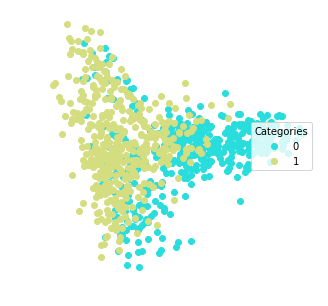

In [10]:
#Plot data's projection on two dimensions. 
#This is a simplified visualization to see if the data are separatable on a two-dimensional space. 

def plotter(X, y):
    fig, ax = plt.subplots(figsize = (5,5))
    
    pca = sklearn.decomposition.PCA(n_components = 2)
    reduced_data = pca.fit_transform(X.toarray())
    transformedDF = pandas.DataFrame({'vect' : [r for r in reduced_data], 'category' : y})

    
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(transformedDF['category'])))
    
    for i, cat in enumerate(set(transformedDF['category'])):
        a = np.stack(transformedDF['vect'][transformedDF['category'] == cat])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()
    
plotter(X_train, y_train)

<span style="color:green"> I use 10-fold cross validation to test the performance of all classifier, including logistic regression and naive bayes. 

<span style="color:green"> I get pretty high accuracy score (both training set and test set) out of 10-fold cross validation. At the first sight, this seems to be an easy classification task so it doesn't really matter what classifier I choose. (*Note.* I do not plot confusion matrix becuase the PCA feature extraction shown below works better, so I evaulate model performance more in the next section.)

In [20]:
#10-fold cross validation
def cross_val(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    kf = KFold(n_splits=10, shuffle= True)
    for train_index, test_index in kf.split(X):

        X_train_string, X_test_string = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #print(train_index)

        vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=800, min_df=3)
        X_train = vectorizer.fit_transform(X_train_string)
        X_test= vectorizer.transform(X_test_string)

        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train.toarray(), y_train)

        y_train_pred= clf.predict(X_train.toarray())
        #print(accuracy_score(y_train, y_train_pred))
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]

        y_test_pred= clf.predict(X_test.toarray())
        #print(accuracy_score(y_test, y_test_pred))
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
    return train_accuracy, test_accuracy



In [21]:
X= clf_DF["gender_string"]
y= clf_DF["gender"]

In [22]:
clf_naive = sklearn.naive_bayes.GaussianNB()
clf_SVClinear = sklearn.svm.SVC(kernel = 'linear', probability = True) 
clf_SVCrbf = sklearn.svm.SVC(kernel = 'rbf', degree = 3, probability = True) 
clf_KNN = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')
clf_lr = sklearn.linear_model.LogisticRegression()
clf_tree = sklearn.tree.DecisionTreeClassifier()
clf_forest = sklearn.ensemble.RandomForestClassifier()
clf_neural = sklearn.neural_network.MLPClassifier()
clf_ensemble = sklearn.ensemble.GradientBoostingClassifier()

clf_collection= {"clf_naive": clf_naive, "clf_lr": clf_lr,
                "clf_SVClinear": clf_SVClinear,
                "clf_SVCrbf": clf_SVCrbf, "clf_KNN": clf_KNN, "clf_tree": clf_tree,
                "clf_forest": clf_forest, "clf_neural": clf_neural, "clf_ensemble": clf_ensemble}

In [23]:
for name, clf in clf_collection.items():

    train_accuracy, test_accuracy= cross_val(X, y, clf)
    
    print("classifier:", name)
    print("average training set accuracy:", np.mean(train_accuracy))
    print("average test set accuracy:", np.mean(test_accuracy))
    print()

classifier: clf_naive
average training set accuracy: 0.874333333333
average test set accuracy: 0.838

classifier: clf_KNN
average training set accuracy: 1.0
average test set accuracy: 0.779

classifier: clf_forest
average training set accuracy: 0.996555555556
average test set accuracy: 0.853

classifier: clf_ensemble
average training set accuracy: 1.0
average test set accuracy: 0.898

classifier: clf_SVCrbf
average training set accuracy: 0.569555555556
average test set accuracy: 0.538

classifier: clf_neural
average training set accuracy: 1.0
average test set accuracy: 0.906

classifier: clf_SVClinear
average training set accuracy: 0.960333333333
average test set accuracy: 0.896

classifier: clf_lr
average training set accuracy: 0.924222222222
average test set accuracy: 0.879

classifier: clf_tree
average training set accuracy: 1.0
average test set accuracy: 0.742



##### <span style="color:green"> 2.2. CountVectorizer + pca

<span style="color:green"> Rather than combining tf-idf feature weighting with PCA, I perform the simple CountVectorizer to calculat the frequency of each words, then use PCA to extract features out of the plain word-frequency count. 

<span style="color:green"> I first make one split of the dataset 

In [31]:
X_train_string, X_test_string, y_train, y_test= train_test_split(clf_DF["gender_string"], clf_DF["gender"], test_size= 0.1)

In [32]:
vectorizer= sklearn.feature_extraction.text.CountVectorizer()
X_train_wordfeq= vectorizer.fit_transform(X_train_string)
X_test_wordfeq= vectorizer.transform(X_test_string)

In [33]:
pca = sklearn.decomposition.PCA(n_components = 200)
X_train = pca.fit_transform(X_train_wordfeq.toarray())
X_test= pca.transform(X_test_wordfeq.toarray())


<span style="color:green"> I test 

    1) which classifier works the best with the pca factors? 
    2) Out of 200 PCA factors, how many should be included in the classification model?

<span style="color:green"> --> Considering the generalization from training set to test set, logistic regression work the best with 150 factors. 

In [34]:
clf_collection= {"clf_naive": clf_naive, "clf_lr": clf_lr}
#"clf_SVClinear": clf_SVClinear,
#"clf_SVCrbf": clf_SVCrbf, "clf_KNN": clf_KNN, "clf_tree": clf_tree,
#"clf_forest": clf_forest, "clf_neural": clf_neural, "clf_ensemble": clf_ensemble

for name, clf in clf_collection.items():      
        print("classifier:", name)     
        for i in [50, 100, 150, 200]:
            print(i)      
            clf.fit(X_train[:, :i], y_train)

            y_train_pred= clf.predict(X_train[:, :i])
            print("training's accuracy: ", accuracy_score(y_train, y_train_pred))

            y_test_pred= clf.predict(X_test[:, :i])
            print("testing's accuracy: ", accuracy_score(y_test, y_test_pred))
        print()    

classifier: clf_lr
50
training's accuracy:  0.953333333333
testing's accuracy:  0.92
100
training's accuracy:  0.97
testing's accuracy:  0.94
150
training's accuracy:  0.968888888889
testing's accuracy:  0.93
200
training's accuracy:  0.987777777778
testing's accuracy:  0.91

classifier: clf_naive
50
training's accuracy:  0.768888888889
testing's accuracy:  0.75
100
training's accuracy:  0.772222222222
testing's accuracy:  0.73
150
training's accuracy:  0.783333333333
testing's accuracy:  0.7
200
training's accuracy:  0.792222222222
testing's accuracy:  0.69



In [18]:
clf_lr.fit(X_train[:, :150], y_train)

y_train_pred= clf_lr.predict(X_train[:, :150])
#print("training's accuracy: ", accuracy_score(y_train, y_train_pred))

y_test_pred= clf_lr.predict(X_test[:, :150])
#print("testing's accuracy: ", accuracy_score(y_test, y_test_pred))

Confusion matrix, without normalization
[[46  5]
 [ 3 46]]
Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.06  0.94]]


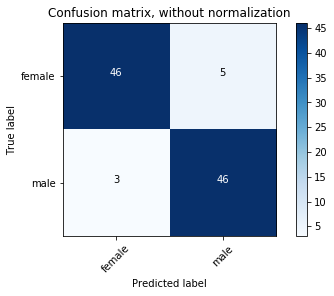

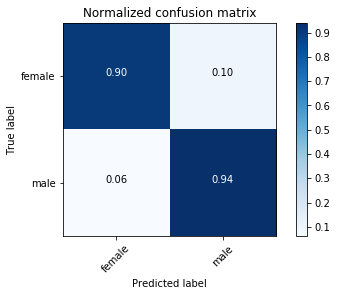

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names= np.array(["female", "male"])
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

<span style="color:green"> For the logistic regression, what's its performance in 10-fold cross validation?

In [41]:
def cross_val_pca(X, y, clf):
    train_accuracy= []
    test_accuracy= []
    
    train_precision= []
    test_precision= []

    train_recall= []
    test_recall= []
    
    train_f1= []
    test_f1= []
    
    kf = KFold(n_splits=10, shuffle= True)
    
    for train_index, test_index in kf.split(X):

        X_train_string, X_test_string = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        vectorizer= sklearn.feature_extraction.text.CountVectorizer()
        X_train_wordfeq= vectorizer.fit_transform(X_train_string)
        X_test_wordfeq= vectorizer.transform(X_test_string)

        pca = sklearn.decomposition.PCA(n_components = 150)
        X_train = pca.fit_transform(X_train_wordfeq.toarray())
        X_test= pca.transform(X_test_wordfeq.toarray())
        
    
        #Fitting the classifier, clf is defined outside of this function
        clf.fit(X_train, y_train)
        
        y_train_pred= clf.predict(X_train)
        y_test_pred= clf.predict(X_test)
        
        ##Accuracy score of training and test set
        
        train_accuracy+= [accuracy_score(y_train, y_train_pred)]
        test_accuracy+= [accuracy_score(y_test, y_test_pred)]
        
        ##Precision score of training and test set
        train_precision+= [precision_score(y_train, y_train_pred)]
        test_precision+= [precision_score(y_test, y_test_pred)]
        
        ##Recall score of training and test set
        train_recall+= [recall_score(y_train, y_train_pred)]
        test_recall+= [recall_score(y_test, y_test_pred)]
        
        ##F1 score of training and test set
        train_f1+= [f1_score(y_train, y_train_pred)]
        test_f1+= [f1_score(y_test, y_test_pred)]
        
    summaryDF= pd.DataFrame({"train_accuracy": train_accuracy,
                             "test_accuracy": test_accuracy,
                             "train_precision": train_precision,
                             "test_precision": test_precision,
                             "train_recall": train_recall,
                             "test_recall": test_recall,
                             "train_f1": train_f1,
                             "test_f1": test_f1})
    
    
    return summaryDF

In [42]:
X= clf_DF["gender_string"]
y= clf_DF["gender"]

In [43]:
cross_val_pca(X, y, clf_lr)

,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.75,0.766355,0.706897,0.836735,0.868889,0.873118,0.847599,0.900222
1,0.89,0.899083,0.875000,0.924528,0.862222,0.864035,0.847312,0.881432
2,0.73,0.747664,0.754717,0.740741,0.860000,0.860927,0.847826,0.874439
3,0.75,0.752475,0.745098,0.760000,0.868889,0.872294,0.850211,0.895556
4,0.81,0.815534,0.823529,0.807692,0.872222,0.874317,0.856531,0.892857
5,0.79,0.810811,0.833333,0.789474,0.857778,0.858093,0.843137,0.873589
6,0.71,0.718447,0.660714,0.787234,0.877778,0.880952,0.864119,0.898455
7,0.80,0.782609,0.800000,0.765957,0.858889,0.864171,0.838174,0.891832
8,0.80,0.807692,0.763636,0.857143,0.858889,0.861202,0.849138,0.873614
9,0.85,0.842105,0.754717,0.952381,0.865556,0.871686,0.847423,0.897380


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

<span style="color:green"> According to the exercise above, 150 PCA factor works the best. I will proceed with this, (although different classifier may work differently...)

In [8]:
X_train_string, X_test_string, y_train, y_test= train_test_split(clf_DF["gender_string"], clf_DF["gender"], test_size= 0.1)

In [9]:
vectorizer= sklearn.feature_extraction.text.CountVectorizer()
X_train_wordfeq= vectorizer.fit_transform(X_train_string)
X_test_wordfeq= vectorizer.transform(X_test_string)

pca = sklearn.decomposition.PCA(n_components = 150)
X_train = pca.fit_transform(X_train_wordfeq.toarray())
X_test= pca.transform(X_test_wordfeq.toarray())

<span style="color:green"> A deeper tree have a high accuracy for the training set, but does not generalize well to the test set. A 7-level tree probably works the best. 

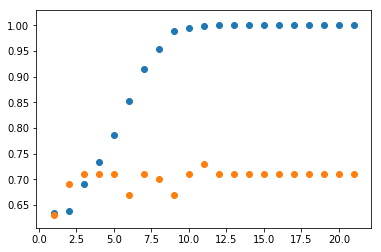

In [46]:
depthvec = []
scorevec_train = []
scorevec_test= []
for i in range(1,22):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(X_train, y_train)
    
    y_train_pred= tree2.predict(X_train)
    y_test_pred= tree2.predict(X_test)
    
    score_train = sklearn.metrics.accuracy_score(y_train, y_train_pred)
    score_test= sklearn.metrics.accuracy_score(y_test, y_test_pred)
    
    depthvec.append(i)
    scorevec_train.append(score_train)
    scorevec_test.append(score_test)
    
plt.scatter(depthvec,scorevec_train)
plt.scatter(depthvec,scorevec_test)
plt.show()

<span style="color:green"> Bagging the tree into random forest. It does not necessarily generate a higher accuray rate. (But it seems to depend on the split. It is not as impressive the last time I tried it. I need a cross-validation to validate the accuracy score.)

In [52]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=7,random_state=0)
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) 
bag.fit(X_train, y_train)

y_train_pred= bag.predict(X_train)
y_test_pred= bag.predict(X_test)

print("training's accuracy: ", accuracy_score(y_train, y_train_pred))
print("testing's accuracy: ", accuracy_score(y_test, y_test_pred))


training's accuracy:  0.997777777778
testing's accuracy:  0.67


<span style="color:green"> I tried to modify the function 'plotregions()' to visualize how decision tree draws decision boundaries. But I really can't... Every time I run this function, it kills the kernel...

In [ ]:
# I stole this function from lucem_illud and made some modification, 
#but it kep killing the kernel!!! 
#CONFUSED

"""
def plotregions(clf, X, y, h = .01):

    pca = sklearn.decomposition.PCA(n_components = 2)
    reduced_data = pca.fit_transform(X)
    transformedDF = pandas.DataFrame({'vect' : [r for r in reduced_data], 'category' : y})
    

    catsMap = {c : i for i, c in enumerate(np.unique(y))}

    fig, ax = plt.subplots(figsize = (10,10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors = len(set(transformedDF['category'])))


    xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
            1.1 * reduced_data[:,0].max(), h),
        np.arange(1.1 * reduced_data[:,1].min(),
            1.1 * reduced_data[:,1].max(), h))
    Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    for i, cat in enumerate(set(y)):
        a = np.stack(transformedDF[transformedDF['category'] == cat])
        ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    plt.show()
    plt.close()

plotregions(tree, X_test, y_test, h = .01)

"""

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [72]:
X_train_string, X_test_string, y_train, y_test= train_test_split(clf_DF["gender_string"], clf_DF["gender"], test_size= 0.1)

In [73]:
vectorizer= sklearn.feature_extraction.text.CountVectorizer()
X_train_wordfeq= vectorizer.fit_transform(X_train_string)
X_test_wordfeq= vectorizer.transform(X_test_string)

pca = sklearn.decomposition.PCA(n_components = 150)
X_train = pca.fit_transform(X_train_wordfeq.toarray())
X_test= pca.transform(X_test_wordfeq.toarray())

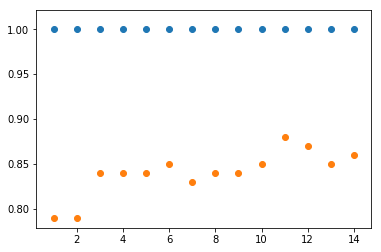

In [74]:
#KNN's k vs. accuracy scores of training set and test set
#K= 6 probably works the best (or 7 or 8, could be a bit random depending on the codes above)

depthvec = []
scorevec_train = []
scorevec_test= []
for i in range(1,15):
    KNN = sklearn.neighbors.KNeighborsClassifier(i, weights='distance')
    KNN.fit(X_train, y_train)
    
    y_train_pred= KNN.predict(X_train)
    y_test_pred= KNN.predict(X_test)
    
    score_train = sklearn.metrics.accuracy_score(y_train, y_train_pred)
    score_test= sklearn.metrics.accuracy_score(y_test, y_test_pred)
    
    depthvec.append(i)
    scorevec_train.append(score_train)
    scorevec_test.append(score_test)
    
plt.scatter(depthvec,scorevec_train)
plt.scatter(depthvec,scorevec_test)
plt.show()

In [30]:
clf_KNN = sklearn.neighbors.KNeighborsClassifier(6, weights='distance')
clf_KNN.fit(X_train, y_train)

y_train_pred= clf_KNN.predict(X_train)
y_test_pred= clf_KNN.predict(X_test)

print("training set's accuracy:", accuracy_score(y_train, y_train_pred))
print("training set's precision:", precision_score(y_train, y_train_pred))
print("training set's recall:", recall_score(y_train, y_train_pred))
print()

print("test set's accuracy:", accuracy_score(y_test, y_test_pred))
print("test set's precision:", precision_score(y_test, y_test_pred))
print("test set's recall:", recall_score(y_test, y_test_pred))
    

training set's accuracy: 1.0
training set's precision: 1.0
training set's recall: 1.0

test set's accuracy: 0.88
test set's precision: 0.84
test set's recall: 0.913043478261


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [75]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(X_train, y_train)

y_train_pred= clf_nn.predict(X_train)
y_test_pred= clf_nn.predict(X_test)

print("training set's accuracy:", accuracy_score(y_train, y_train_pred))
print("training set's precision:", precision_score(y_train, y_train_pred))
print("training set's recall:", recall_score(y_train, y_train_pred))
print()

print("test set's accuracy:", accuracy_score(y_test, y_test_pred))
print("test set's precision:", precision_score(y_test, y_test_pred))
print("test set's recall:", recall_score(y_test, y_test_pred))

training set's accuracy: 0.998888888889
training set's precision: 0.997802197802
training set's recall: 1.0

test set's accuracy: 0.86
test set's precision: 0.833333333333
test set's recall: 0.869565217391
